<a href="https://colab.research.google.com/github/hyewon328/Bigcontest/blob/master/3_Iceberg_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statoil/C-CORE Iceberg Classifier Challenge**

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

## 1. Load and understand the data


 data is from [https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data](https://)



*   band_1, band_2: the **flattened** image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). 


*   inc_angle: the incidence angle of which the image was taken
*   is_iceberg: the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. 








In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df=pd.read_json('/content/gdrive/My Drive/iceberg/train.json')

In [4]:
df.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


## 2. Data Preprocessing

**What is HH and HV?** <br>
Sentinal Settalite is equivalent to RISTSAT(an Indian remote sensing Sat) and they only Transmit pings in H polarization, AND NOT IN V polarization. Those H-pings gets scattered, objects change their polarization and returns as a mix of H and V. Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only. <br>

Now, we are going to make 3 channels of RGB by extracting band_1(HH), band_2
(HV) and band_3, which is the average of those two.



In [0]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75,75) for band in df['band_1']])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75,75) for band in df['band_2']])

In [6]:
print(X_band_1.shape)
print(X_band_2.shape)

(1604, 75, 75)
(1604, 75, 75)


In [0]:
# make X_train data by concatenating X_band_1, X_band_2, and their average.
X_train=np.concatenate([X_band_1[:,:,:,np.newaxis],X_band_2[:,:,:,np.newaxis],((X_band_1+X_band_2)/2)[:,:,:,np.newaxis]],axis=-1)

**cf** <br>


*   `np.newaxis`: numpy.newaxis is used to increase the dimension of the existing array by one more dimension



In [8]:
# X_band_1 dimension change due to np.newaxis
print(X_band_1.shape)
print(X_band_1[:,:,:,np.newaxis].shape)

(1604, 75, 75)
(1604, 75, 75, 1)


In [9]:
X_train.shape

(1604, 75, 75, 3)

**Grahp iceberg**

In [10]:
! pip install chart_studio

     |████████████████████████████████| 71kB 2.5MB/s 


In [11]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

In [0]:
def plot3d(c,name):
  data=[go.Surface(z=c)]
  layout=go.Layout(title=name,autosize=False,width=700,height=700,
                   margin=dict(l=65,r=50,b=65,t=90))
  fig=go.Figure(data=data,layout=layout)
  py.iplot(fig)
  fig.show()

In [0]:
plot3d(X_band_1[12,:,:], 'iceberg')

In [0]:
plot3d(X_band_1[14,:,:], 'Ship')

## 3. Modeling - CNN

In [15]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [0]:
def getModel():
  model=Sequential()
  # Layer 1
  model.add(Conv2D(64,3,activation='relu',input_shape=(75,75,3)))
  model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
  model.add(Dropout(0.2))

  # Layer 2
  model.add(Conv2D(128,3,activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.2))

  # Layer 3
  model.add(Conv2D(128,3,activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.2))

  # Layer 4
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())

  #Dense Layers
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #Dense Layer 2
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #Sigmoid Layer
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  #Optimizer
  optim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(loss='binary_crossentropy',optimizer=optim,metrics=['accuracy'])
  model.summary()
  return model


**Callback** <br>
Too many epochs cause overfitting and the opposite causes underfitting problems. We use **callback** to solve this. <br>

`from keras.callbacks import EarlyStopping, ModelCheckpoint` <br>

Reference: [https://3months.tistory.com/424](https://)

*   EarlyStopping: 
 + monitor: monitor 할 대상 ex) val_loss: monitor validation loss
 + mode: 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정한다. 예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, ‘min’으로 설정된다.
 + patience: 성능이 증가하지 않는 epoch 를 몇번 허용할것인지 판단한다.


*   ModelCheckpoint: save best parameters if validation performance is good








In [0]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = "/content/gdrive/My Drive/iceberg/model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [18]:
callbacks

In [0]:
target_train=df['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, test_size=0.25)

In [37]:
import os
gmodel=getModel()
model=gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [21]:
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - 2s 5ms/step
Test loss: 0.2959248202845937
Test accuracy: 0.8678303956985474


## 4. Test set and predict

In [0]:
test=pd.read_json('/content/gdrive/My Drive/iceberg/test.json')
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

In [24]:
test.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [0]:
preds=[1 if x>0.5 else 0 for x in predicted_test]

<Figure size 720x720 with 0 Axes>

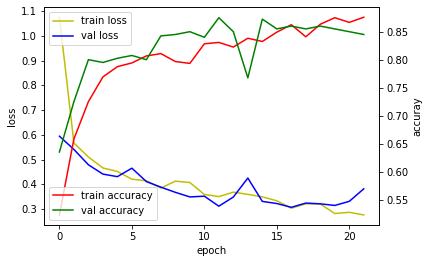

In [44]:
plt.figure(figsize=(10,10))


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
epoch=50
loss_ax.plot(model.history['loss'],'y',label='train loss')
loss_ax.plot(model.history['val_loss'],'b',label='val loss')
acc_ax.plot(model.history['accuracy'],'r',label='train accuracy')
acc_ax.plot(model.history['val_accuracy'],'g',label='val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')